In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar  
import math

In [2]:
N = norm.cdf


In [3]:
# import sympy as sp
# import sympy.stats
# n = sympy.stats.Normal('n', 0, 1)


In [4]:
from scipy.special import erf
print(erf(1))

0.8427007929497148


In [5]:
print(N(1))
print(norm.rvs())

0.8413447460685429
0.7569753184135536


## Setting up the params

In [129]:
option = {"T": 0.5, "x0": 250, "K": 1000, "r": 0, "sigma": 0.7}


In [130]:
option['x0']

250

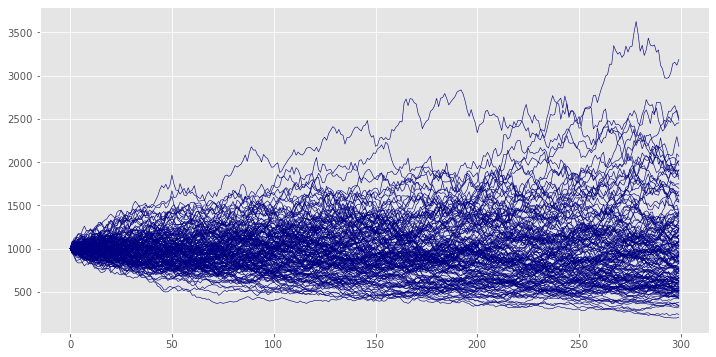

In [131]:
# geometric bwornian motions
# TODO: add taking account of risk-free rate while sampling


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


sigma = option['sigma']
T = option['T']
K = option['K']

steps = 300
num_plots = 150
Range = []
Values = [K]


plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 1))))


Range = np.arange(steps) 

all_paths = []

for i in range(0, num_plots):

    for i in range (1, steps):
        dx = sigma * Values[-1] * norm.rvs() * np.sqrt(T / steps)

        y = Values[-1] + dx

        Values.append(y)
    all_paths.append(Values)
    ax.plot(Range, Values)
    Values = [K]

In [132]:
def delta_BS_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1) - 1

def delta_BS_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1)

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T)* N(-d2) - S * N(-d1)

### This is the process of BS call replication (below):

In [133]:
# delta_BS_put(100,100,0.5, 0, 1)
last_prices = []
call_replicated_payoff = []
call_true_payoff = []

S0 = option['K']
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']

asset = 0
initial_usdc = 200
usdc = initial_usdc
prev_asset = 0

for i in range(len(all_paths[:])):
    asset = 0
    initial_usdc = 200
    usdc = initial_usdc
    prev_asset = 0
    
    for j in range(len(all_paths[i])):
        t = (T / steps) * j
        prev_asset = asset
        asset = delta_BS_call(all_paths[i][j], K, T - t, r, sigma)
        usdc = usdc - (asset - prev_asset) * all_paths[i][j] 
#         print(asset, usdc)

    last_prices.append(all_paths[i][-1])
    call_replicated_payoff.append(asset*all_paths[i][-1] + usdc - initial_usdc)
    
    call_true_payoff.append(max(0, all_paths[i][-1] - K) - BS_CALL(S0, K, T, r, sigma))

# print(all_paths[1][-1])
# print(asset*all_paths[1][-1]+ usdc)
        

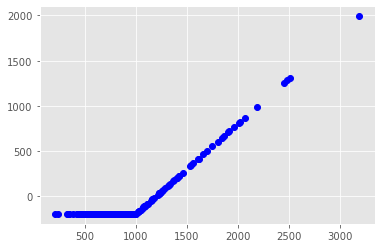

In [134]:
plt.plot(last_prices, call_true_payoff, 'bo', )


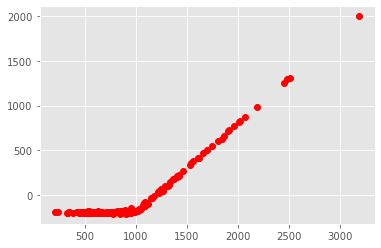

In [135]:
plt.plot(last_prices, call_replicated_payoff, 'ro')

## The replication of put option with curved payoff to hedge against impermanent losses

In [136]:
# This function is correct
def BS_root_put(x0, S, K, T, r, sigma):
    TV0 = 2 * x0
    z1 = -(np.log(S/K) + (r - 0.5*sigma**2)*T)/np.sqrt(T)/sigma

    
    first_part = (np.exp(-r*T) * TV0) * N(z1)
    _r = r/2
    _sigma = sigma / 2
    z2 = z1 - _sigma * np.sqrt(T)
    second_part = (np.exp(-r*T) * TV0*np.sqrt(S/K)) * (np.exp(-0.5 * _sigma**2 * T)*np.exp(_r*T)) * N(z2)
    
    return first_part - second_part
    


In [137]:
def new_way_BS_delta_root_put(x0, S, K, T, r, sigma):
    z1 = -(np.log(S/K) + (r - 0.5*sigma**2)*T)/np.sqrt(T)/sigma
    _r = r/2
    _sigma = sigma / 2
    z2 = z1 - _sigma * np.sqrt(T)
    return -(np.exp(-r*T) * x0 / np.sqrt(K*S)) * (np.exp(-0.5 * _sigma**2 * T)*np.exp(_r*T)) * N(z2)

In [138]:
# delta_BS_put(100,100,0.5, 0, 1)
last_prices = []
root_put_replicated_payoff = []
root_put_true_payoff = []

# x0 = 50
# y0 = x0 / K


# S0 = option['K']
x0 = option['x0']
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']

for i in range(len(all_paths[:])):
    asset = 0  
    initial_usdc = 0
    usdc = initial_usdc
    prev_asset = asset
    
    for j in range(len(all_paths[i])):
        t = (T / steps) * j
        prev_asset = asset
        asset = new_way_BS_delta_root_put(x0, all_paths[i][j], K, T-t, r, sigma)
        usdc = usdc - (asset - prev_asset) * all_paths[i][j] 
#         print(asset, usdc)

    last_prices.append(all_paths[i][-1])
    root_put_replicated_payoff.append(asset*all_paths[i][-1] + usdc - initial_usdc)
    
    root_put_true_payoff.append(max(0, (2*x0) - (2*np.sqrt(x0**2 / K))* np.sqrt(all_paths[i][-1]) ) - BS_root_put(x0, K, K, T, r, sigma))

# print(all_paths[1][-1])
# print(asset*all_paths[1][-1]+ usdc)
        

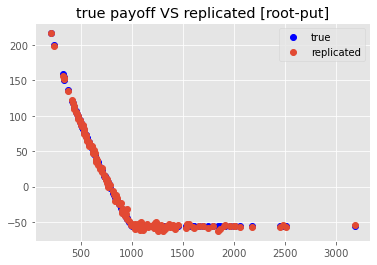

In [139]:
print(plt.plot(last_prices, root_put_true_payoff, 'bo'))
print(plt.plot(last_prices, root_put_replicated_payoff, 'o'))
plt.title('true payoff VS replicated [root-put]')
plt.legend(['true', 'replicated'])
# plt.xlim(xmax=150)

### The final total value portfolio of a liquidity provider with curved option hedging:

In [140]:
# np.array(replicated_payoff)

In [141]:
# x0 - amount in usdc
# y0 = x0 / K
# K - eth price at the moment of providing liquidity to AMM
# S - eth price at the maturity of option

def uniswapV2_TV(x0,K,S):
    return 2*x0*np.sqrt(S/K)

In [142]:
last_prices = np.array(last_prices)

In [143]:
x0 = option['x0']
# S0 = option['K']
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']


uniV2_tvs = np.array([uniswapV2_TV(x0, K, price) for price in last_prices])

In [144]:

HODLETH = [(2*x0 / K)*price for price in sorted(last_prices)]
# HODL

In [145]:
PURE_USDC = [2*x0]*len(last_prices)

(28.79426613073008, 1000.0)

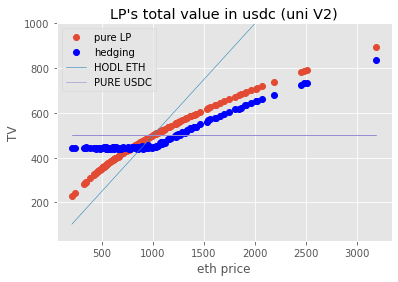

In [146]:
print(plt.plot(last_prices, uniV2_tvs, 'o'))
print(plt.plot(last_prices, uniV2_tvs + root_put_replicated_payoff, "bo"))
print(plt.plot(sorted(last_prices), HODLETH))
print(plt.plot(last_prices, PURE_USDC))
plt.xlabel('eth price')
plt.ylabel('TV')
plt.title("LP's total value in usdc (uni V2)")
plt.legend(['pure LP', 'hedging', 'HODL ETH', 'PURE USDC'])
plt.ylim(ymax=1000)

Text(0.5, 1.0, 'root-put delta')

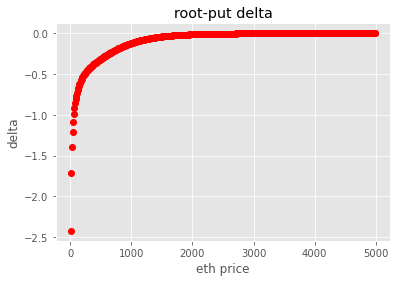

In [147]:
stock_prices = [x for x in range(10, 5*K, 10)]


x0 = option['x0']
S0 = option['K']
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']


put_prices = [new_way_BS_delta_root_put(x0, price, K, T, r, sigma) for price in stock_prices]

print(plt.plot(stock_prices, put_prices, 'ro'))
plt.xlabel('eth price')
plt.ylabel('delta')
plt.title('root-put delta')

## Short 'root' call replication:

In [148]:
def BS_root_call(x0, S, K, T, r, sigma):
    TV0 = 2 * x0
    z1 = -(np.log(S/K) + (r - 0.5*sigma**2)*T)/np.sqrt(T)/sigma

    
    first_part = (np.exp(-r*T) * TV0) * N(-z1)
    _r = r/2
    _sigma = sigma / 2
    z2 = z1 - _sigma * np.sqrt(T)
    second_part = (np.exp(-r*T) * TV0*np.sqrt(S/K)) * (np.exp(-0.5 * _sigma**2 * T)*np.exp(_r*T)) * N(-z2)
    
    return -first_part + second_part
    

In [149]:
def delta_BS_root_call(x0, S, K, T, r, sigma):
    z1 = -(np.log(S/K) + (r - 0.5*sigma**2)*T)/np.sqrt(T)/sigma
    _r = r/2
    _sigma = sigma / 2
    z2 = z1 - _sigma * np.sqrt(T)
    
    return (np.exp(-r*T) * x0 / np.sqrt(K*S)) * (np.exp(-0.5 * _sigma**2 * T)*np.exp(_r*T)) * N(-z2)

In [150]:
x0 = option['x0']
S0 = option['K'] #1000
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']

In [151]:
# strikes = [x for x in range(100, 2000)]
# prices_bs_root_call = [BS_root_call(x0, S0, strike, T, r, sigma) for strike in strikes]
# deltas_bs_root_call = [delta_BS_root_call(x0, S0, strike, T, r, sigma) for strike in strikes]

In [152]:
# plt.plot(strikes, prices_bs_root_call)

In [153]:
# plt.plot(strikes, deltas_bs_root_call)

In [154]:
# delta_BS_put(100,100,0.5, 0, 1)
last_prices = []
root_call_replicated_payoff = []
root_call_true_payoff = []

# x0 = 50
# y0 = x0 / K


# S0 = option['K']
x0 = option['x0']
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']

for i in range(len(all_paths[:])):
    asset = 0  
    initial_usdc = 0
    usdc = initial_usdc
    prev_asset = asset
    
    for j in range(len(all_paths[i])):
        t = (T / steps) * j
        prev_asset = asset
        asset = delta_BS_root_call(x0, all_paths[i][j], K, T-t, r, sigma)
        usdc = usdc - (asset - prev_asset) * all_paths[i][j] 
#         print(asset, usdc)

    last_prices.append(all_paths[i][-1])
    root_call_replicated_payoff.append(asset*all_paths[i][-1] + usdc - initial_usdc)
    
    root_call_true_payoff.append(max(0, (2*np.sqrt(x0**2 / K))* np.sqrt(all_paths[i][j]) - (2*x0)) - BS_root_call(x0, K, K, T, r, sigma))

# print(all_paths[1][-1])
# print(asset*all_paths[1][-1]+ usdc)
        

Text(0.5, 0, 'eth price')

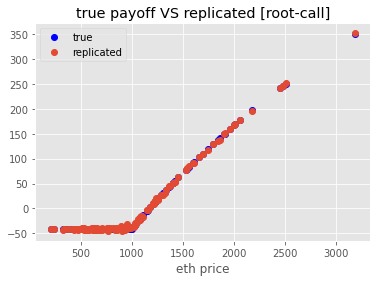

In [155]:
print(plt.plot(last_prices, root_call_true_payoff, 'bo'))
print(plt.plot(last_prices, root_call_replicated_payoff, 'o'))
plt.title('true payoff VS replicated [root-call]')
plt.legend(['true', 'replicated'])
plt.xlabel('eth price')
# plt.xlim(xmax=150)

## If user wants to replicate the short root-call option:

In [156]:
last_prices = []
short_root_call_replicated_payoff = []
short_root_call_true_payoff = []

# x0 = 50
# y0 = x0 / K


# S0 = option['K']
x0 = option['x0']
K = option['K'] * 1.25
T = option['T']
r = option['r']
sigma = option['sigma']

for i in range(len(all_paths[:])):
    asset = 0  
    initial_usdc = 0
    usdc = initial_usdc
    prev_asset = asset
    
    for j in range(len(all_paths[i])):
        t = (T / steps) * j
        prev_asset = asset
        asset = -delta_BS_root_call(x0, all_paths[i][j], K, T-t, r, sigma)
        usdc = usdc - (asset - prev_asset) * all_paths[i][j] 
#         print(asset, usdc)

    last_prices.append(all_paths[i][-1])
    short_root_call_replicated_payoff.append(asset*all_paths[i][-1] + usdc - initial_usdc)
    
#     short_root_call_true_payoff.append(-(max(0, (2*np.sqrt(x0**2 / K))* np.sqrt(all_paths[i][j]) - (2*x0)) - BS_root_call(x0, K, K, T, r, sigma)))

# print(all_paths[1][-1])
# print(asset*all_paths[1][-1]+ usdc)
        

Text(0.5, 0, 'eth price')

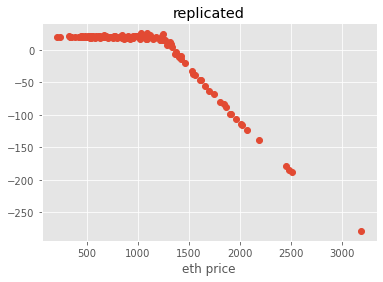

In [157]:
# print(plt.plot(last_prices, (short_root_call_true_payoff), 'bo'))
print(plt.plot(last_prices, (short_root_call_replicated_payoff), 'o'))
plt.title('replicated')
# plt.legend(['true', 'replicated'])
plt.xlabel('eth price')
# plt.xlim(xmax=150)

### Combining the uniswap V2 LP position, long put, short call together:
#### Suppose strike of short call is: $1.5 K$

In [158]:
short_root_call_replicated_payoff = np.array(short_root_call_replicated_payoff)

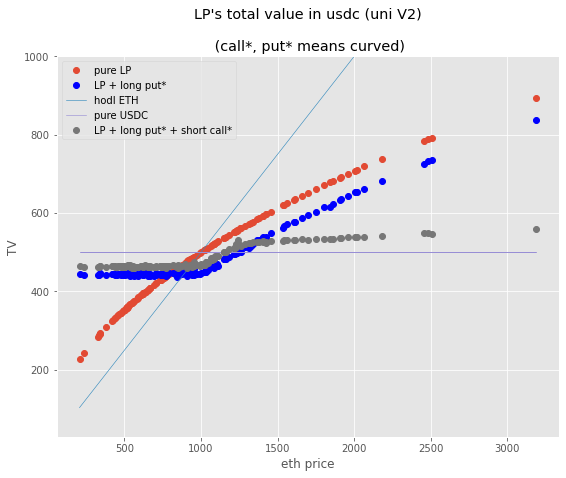

In [196]:
print(plt.plot(last_prices, uniV2_tvs, 'o'))
print(plt.plot(last_prices, uniV2_tvs + root_put_replicated_payoff, "bo"))
print(plt.plot(sorted(last_prices), HODLETH))
print(plt.plot(last_prices, PURE_USDC))
print(plt.plot(last_prices, uniV2_tvs + root_put_replicated_payoff + short_root_call_replicated_payoff, "o"))
plt.xlabel('eth price')
plt.ylabel('TV')
plt.title("LP's total value in usdc (uni V2)\n\n (call*, put* means curved)")
plt.legend(['pure LP', 'LP + long put*', 'hodl ETH', 'pure USDC', 'LP + long put* + short call*'])
plt.ylim(ymax=1000)
plt.rcParams["figure.figsize"] = (9,7)

In [18]:
from scipy.integrate import quad

In [107]:
x0 = option['x0']
S0 = option['K']
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']

In [109]:
BS_root_put(x0, S0, K, T, r, sigma)

69.95634063620128

In [20]:
# This function works correctly

# S is the price at time t (not T)
def num_new_way_BS_delta_root_put(z, x0, S, K, T, r, sigma):
    return -(2*x0/np.sqrt(K)*(0.5/np.sqrt(S))*np.exp(0.5 * (r - 0.5*sigma**2)*T + 0.5*sigma*np.sqrt(T)*z))*norm.pdf(z)



In [ ]:
# not works
def num_root_put(z, x0, S, K, T, r, sigma):
    
    return -(2*x0/np.sqrt(K)*(0.5/np.sqrt(S))*np.exp(0.5 * (r - 0.5*sigma**2)*T + 0.5*sigma*np.sqrt(T)*z))*norm.pdf(z)
    

In [21]:
x0 = option['x0']
S0 = option['K']
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']

new_way_BS_delta_root_put(x0, K, K, T, r, sigma)


-0.24382747800708315

In [110]:
z2 = -(np.log(S0/K) + (r - 0.5*sigma**2)*T)/np.sqrt(T)/sigma

I = quad(num_new_way_BS_delta_root_put, -100, z2, args=(x0,K,K,T,r,sigma))
I

(-1.1949968522913748, 1.2286935845191086e-12)